In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
import json

import dask.dataframe as dd
import matplotlib.pyplot as plt

from gzreduction.vote_sources.panoptes_exports import export_to_responses
from gzreduction.vote_sources.panoptes_exports import aggregate
from gzreduction.schemas.cd_schema import cd_schema

In [50]:
schema = cd_schema

In [51]:
# classification_export_loc = '/home/walml/repos/gz-panoptes-reduction/data/cosmic_dawn/cosmic-dawn-workflow-classifications_2024-01-11.csv'
# 1,540,876 rows

classification_export_loc = '/home/walml/repos/gz-panoptes-reduction/data/cosmic_dawn/cosmic-dawn-workflow-classifications_2024-01-13.csv'
# 1,649,974 rows (classifications)
# 6.1M responses currently
aggregated_loc = '/home/walml/repos/gz-panoptes-reduction/data/cosmic_dawn/cosmic_dawn_reduced_votes.csv'

In [52]:
# nrows = 10000
nrows = None
clf = pd.read_csv(classification_export_loc, nrows=nrows)
# clf = dd.read_csv(classification_export_loc)
clf

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,445824444,not-logged-in-4b4a3d435cdb35b54f0b,NaN,4b4a3d435cdb35b54f0b,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:10 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81371870"":{""retired"":{""id"":108698450,""workfl...",81371870
1,445824476,not-logged-in-4b4a3d435cdb35b54f0b,NaN,4b4a3d435cdb35b54f0b,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:21 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81398125"":{""retired"":{""id"":108658138,""workfl...",81398125
2,445824529,not-logged-in-e6788d582f20893bc72e,NaN,e6788d582f20893bc72e,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:38 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81416697"":{""retired"":{""id"":108694182,""workfl...",81416697
3,445824555,not-logged-in-6ac01924a7fc82c5d44c,NaN,6ac01924a7fc82c5d44c,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:49 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81417291"":{""retired"":{""id"":108695578,""workfl...",81417291
4,445824629,not-logged-in-532d6ed079255aedc024,NaN,532d6ed079255aedc024,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:18:20 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81361994"":{""retired"":{""id"":108691250,""workfl...",81361994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649969,534001481,peakscience7,1844069.0,6121d2212d4e948ad034,21802,Cosmic Dawn workflow,70.94,2024-01-12 14:12:49 UTC,NaN,NaN,"{""source"":""api"",""session"":""26aa8c50542958aa27e...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""94569380"":{""retired"":null,""!ra"":165.33387632...",94569380
1649970,534001767,not-logged-in-03d326842db72ac5cb0a,NaN,03d326842db72ac5cb0a,21802,Cosmic Dawn workflow,70.94,2024-01-12 14:14:28 UTC,NaN,NaN,"{""source"":""api"",""session"":""43eeafe8897b5da6e90...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""94563088"":{""retired"":{""id"":122930501,""workfl...",94563088
1649971,534002413,not-logged-in-259cf233624aa1b4df57,NaN,259cf233624aa1b4df57,21802,Cosmic Dawn workflow,70.94,2024-01-12 14:18:36 UTC,NaN,NaN,"{""source"":""api"",""session"":""3bf32e31b0a2f1fce45...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""94576142"":{""retired"":null,""!ra"":221.79561321...",94576142
1649972,534002610,Perayb91,2693014.0,804f48534c1132166c4c,21802,Cosmic Dawn workflow,70.94,2024-01-12 14:19:54 UTC,NaN,NaN,"{""source"":""api"",""session"":""93d8f86be8642dd9c6d...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""94563124"":{""retired"":null,""!ra"":39.154426588...",94563124


In [55]:
def get_hsc_subject_id(subject_data):
    # print(subject_data)
    loaded = json.loads(subject_data)
    inner_dict = loaded[list(loaded.keys())[0]]
    for possible_key in ['id', '!id', 'object_id', 'id_str']:
        if possible_key in inner_dict:
            return 'h2o_' + str(inner_dict[possible_key])
        if '!filename' in inner_dict:
            return 'pdr3_' + inner_dict['!filename'].replace('.jpg', '').replace('.png', '')  # object_id.jpg -> object_id
            # TODO loop and replace metadata
    raise KeyError(inner_dict)

In [56]:
clf['id_str'] = clf['subject_data'].apply(get_hsc_subject_id)

In [57]:
clf['id_str'].sample(1000)

590044                 h2o_277550
1066869               h2o_1794101
1134378    pdr3_38535846739077041
1303696    pdr3_40581492417515210
103116                 h2o_605760
                    ...          
770602                h2o_1516463
1524000    pdr3_36420661245131995
1117356                h2o_659952
872867                h2o_1689855
1069172               h2o_1929558
Name: id_str, Length: 1000, dtype: object

In [58]:
clf['id_str'].value_counts()

id_str
h2o_1372474               556
pdr3_39627090554800425    551
h2o_131078                548
h2o_1601852               538
pdr3_40123545824546944    537
                         ... 
pdr3_42182239613646230      1
h2o_807395                  1
pdr3_39608957202884252      1
h2o_651043                  1
pdr3_70360497840479909      1
Name: count, Length: 93462, dtype: int64

In [59]:
clf['in_h2o'] = clf['id_str'].apply(lambda x: x.startswith('h2o'))

In [60]:
clf['in_h2o'].sum()

1241166

In [61]:
clf.sort_values('created_at', inplace=True)

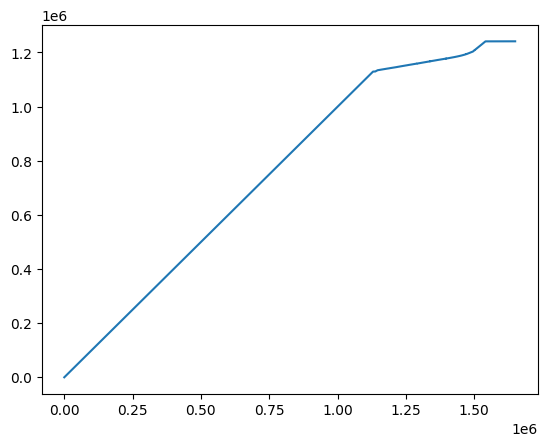

In [62]:
# plt.plot(clf['created_at'], clf['temp'].cumsum())
plt.plot( clf['in_h2o'].cumsum())  # simple range is much quicker

In [64]:
workflows = [21802]
clf = clf[clf['workflow_id'].isin(workflows)]

In [65]:
df = export_to_responses.explode_annotations(clf, exclude_tasks=['T10', 'T12'])
df

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,h2o_265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
0,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,h2o_265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
0,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,h2o_265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
1,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,h2o_356517,NaN,445824476,2022-10-21 14:17:21 UTC,81398125,67.91
1,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,h2o_356517,NaN,445824476,2022-10-21 14:17:21 UTC,81398125,67.91
...,...,...,...,...,...,...,...,...,...
1649972,T1,How rounded is it?,![in_between_shaped.png](https://panoptes-uplo...,pdr3_39626562273826355,2693014.0,534002610,2024-01-12 14:19:54 UTC,94563124,70.94
1649972,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,pdr3_39626562273826355,2693014.0,534002610,2024-01-12 14:19:54 UTC,94563124,70.94
1649973,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,pdr3_42190906857638584,2584478.0,534004098,2024-01-12 14:28:24 UTC,94565248,70.94
1649973,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,pdr3_42190906857638584,2584478.0,534004098,2024-01-12 14:28:24 UTC,94565248,70.94


In [66]:
# minimise memory
del clf
del df['workflow_version']
del clf['in_h2o']
del df['created_at']
del df['user_id']

df = df.drop_duplicates(subset=['classification_id', 'task', 'value'])
# del df['classification_id']

In [67]:
df.reset_index(drop=True, inplace=True)

,task,task_label,value,id_str,classification_id,subject_ids
0,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,h2o_265684,445824444,81371870
1,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,h2o_265684,445824444,81371870
2,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,h2o_265684,445824444,81371870
3,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,h2o_356517,445824476,81398125
4,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,h2o_356517,445824476,81398125
...,...,...,...,...,...,...
6082481,T1,How rounded is it?,![in_between_shaped.png](https://panoptes-uplo...,pdr3_39626562273826355,534002610,94563124
6082482,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,pdr3_39626562273826355,534002610,94563124
6082483,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,pdr3_42190906857638584,534004098,94565248
6082484,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,pdr3_42190906857638584,534004098,94565248


In [68]:
df = export_to_responses.clean_exploded_annotations(df, schema)
# takes 5+ minutes and 40GB mem (not sure why it uses so much memory tbh, I could likely change it to loop/map instead of apply)

In [69]:
aggregated = aggregate.responses_to_reduced_votes(df.reset_index(drop=True), schema)

/home/walml/repos/gz-panoptes-reduction/gzreduction/vote_sources/panoptes_exports/aggregate.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[question.get_fraction_column(answer)] = df[question.get_count_column(answer)] / df[question.total_votes]  # may give nans?
/home/walml/repos/gz-panoptes-reduction/gzreduction/vote_sources/panoptes_exports/aggregate.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[question.get_fraction_column(answer)] = df[question.get_count_column(answer)] / df[question.total_votes]  # may giv

In [70]:
aggregated

question_response,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_star_fraction,problem_artifact_fraction,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,h2o_1000042,2,0,0,1,1,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,h2o_1000067,29,7,4,0,11,18,5,2,1,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,h2o_1000090,2,0,2,0,2,0,0,0,0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,h2o_1000108,5,0,3,5,0,0,0,0,0,...,0.333333,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93458,pdr3_74649155829500852,5,0,0,2,3,0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93459,pdr3_74649155829530250,4,0,1,4,0,0,0,0,0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93460,pdr3_74649160124498823,2,1,1,0,0,2,1,0,0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93461,pdr3_74649164419462887,3,0,1,0,3,0,0,0,0,...,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
aggregated.to_csv(aggregated_loc, index=False)

Some quick graphs

In [72]:
aggregated['smooth-or-featured_smooth'].sum(), aggregated['smooth-or-featured_featured-or-disk'].sum(), aggregated['smooth-or-featured_problem'].sum()

(867499, 358658, 423817)

Text(0.5, 1.0, 'GZ CD Latest Aggregation')

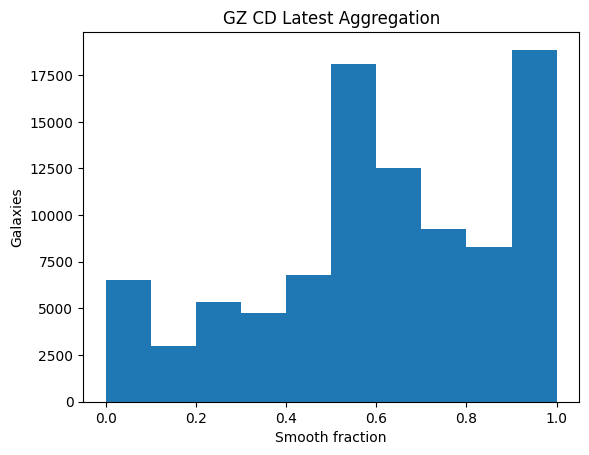

In [73]:
plt.hist(aggregated['smooth-or-featured_smooth_fraction'], bins=10)
plt.xlabel('Smooth fraction')
plt.ylabel('Galaxies')
plt.title('GZ CD Latest Aggregation')

In [77]:
aggregated['smooth-or-featured-cd_total-votes']

0         0
1         2
2        40
3         4
4         8
         ..
93458     5
93459     5
93460     4
93461     4
93462     5
Name: smooth-or-featured-cd_total-votes, Length: 93463, dtype: int64

Text(0.5, 1.0, 'GZ CD Latest Aggregation')

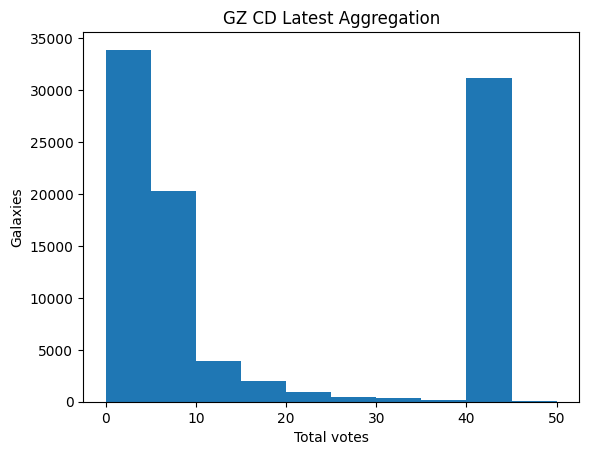

In [79]:
plt.hist(aggregated['smooth-or-featured-cd_total-votes'], bins=10, range=(0, 50))
# plt.xlim([0., 50.])
plt.xlabel('Total votes')
plt.ylabel('Galaxies')
plt.title('GZ CD Latest Aggregation')

Text(0.5, 1.0, 'GZ CD Latest Aggregation')

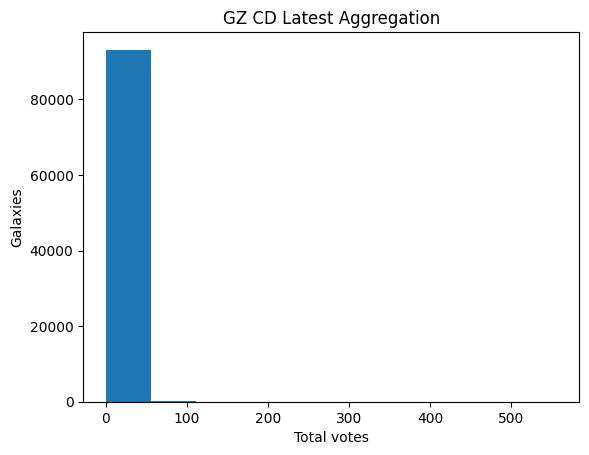

In [80]:
plt.hist(aggregated['smooth-or-featured-cd_total-votes'])
# plt.xlim([0., 50.])
plt.xlabel('Total votes')
plt.ylabel('Galaxies')
plt.title('GZ CD Latest Aggregation')

In [75]:
# tweak catalog to include renamed columns in format {question}-cd_{answer} expected by zoobot ortho schema

from zoobot.shared.schemas import cosmic_dawn_ortho_schema

aggregated = pd.read_csv(aggregated_loc)

renamer = {}
for question in cosmic_dawn_ortho_schema.questions:
  renamer[question.text.replace('-cd', '') + '_total-votes'] = question.text + '_total-votes'
  for answer in question.answers:
    renamer[answer.text.replace('-cd', '')] = answer.text
    renamer[answer.text.replace('-cd', '') + '_fraction'] = answer.text + '_fraction'
# print(renamer)
aggregated = aggregated.rename(columns=renamer)

for label_col in cosmic_dawn_ortho_schema.label_cols:
  assert label_col in aggregated.columns.values, 'Missing {}'.format(label_col)

aggregated.to_csv(aggregated_loc.replace('.csv', '_ortho.csv'), index=False)
